# Sentiment Analysis with IMDb Reviews


I have trained an LSTM model for sentiment analysis with IMDB reviews. This is a binary classification task: for each review, I classify it as having positive or negative sentiment.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# the next two lines are needed on my Intel-based MacBook Air to get the code to run; you likely don't need these two lines...
# (in fact I used to not need these two lines)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
import torch.nn as nn
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy

## Load the dataset

In [ ]:
from torchnlp.datasets import imdb_dataset
torch.manual_seed(0)

In [ ]:
train_dataset = imdb_dataset(train=True)

In [ ]:
len(train_dataset)

25000

In [ ]:
proper_train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - proper_train_size

In [ ]:
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])

In [ ]:
type(proper_train_dataset[0])

dict

In [ ]:
from torchnlp.encoders.text import SpacyEncoder

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
encoder = SpacyEncoder([data['text'] for data in proper_train_dataset])

In [ ]:
proper_train_encoded = [encoder.encode(data['text']) for data in proper_train_dataset]

In [ ]:
len(proper_train_encoded)

20000

In [ ]:
proper_train_encoded[1]

tensor([149, 150, 151,  24, 152, 153,  12, 154, 155, 156, 157,  34, 158,  39,
        159,  34, 160, 161, 133,  85, 162, 163, 164, 165, 166, 167, 168,  22,
        169,  85,  25,  85, 155, 101,  85, 170, 171, 172,  10, 173, 174,  10,
         85, 175,  34, 176, 177, 178, 179,  22, 180, 156, 181,  17, 182, 161,
        183, 184, 185, 111,  20, 186,  39,  85,  76,  19,  85, 187, 188, 189,
        190, 191,  34, 192,  19, 154, 155, 193, 194,  24, 152,  22, 195, 196,
         34, 149, 197,  10, 198, 199,  19,  85, 200, 129, 154, 159,  34, 201,
        202,  19,  85,  25,  64, 203, 204, 177, 205, 188, 206, 207, 208, 209,
        210, 211,  34, 201,  85, 212, 213,  64, 103,  24,  25,  64, 214, 215,
        216,  94, 217, 218,  19,  85, 219, 220, 156, 221, 155, 222, 223, 161,
        224, 225, 188, 226, 188, 227,  22, 228,  64,  17, 229, 230, 231,  19,
        232,  15, 118, 233, 234, 235, 236, 237, 133, 238,  22,  56, 239, 101,
         85, 152, 240,  39, 241,  10, 235, 242,  10, 243, 237, 1

In [ ]:
print([encoder.vocab[word_idx] for word_idx in proper_train_encoded[1]])

['I', 'just', 'saw', 'this', 'movie', 'today', 'with', 'my', 'children', '(', 'son', ',', '10', 'and', 'daughter', ',', '4.5', ')', 'at', 'the', '3rd', 'Annual', 'Roger', 'Ebert', 'Overlooked', 'Film', 'Festival', '.', 'After', 'the', 'film', 'the', 'children', 'in', 'the', 'audience', 'were', 'allowed', 'to', 'ask', 'questions', 'to', 'the', 'Director', ',', 'Tian', '-', 'Ming', 'Wu', '.', 'He', '(', 'through', 'a', 'translator', ')', 'told', 'several', 'stories', 'about', 'his', 'life', 'and', 'the', 'making', 'of', 'the', 'film.<br', '/><br', '/>All', 'tangents', 'aside', ',', 'both', 'of', 'my', 'children', 'really', 'enjoyed', 'this', 'movie', '.', 'Of', 'course', ',', 'I', 'had', 'to', 'paraphrase', 'many', 'of', 'the', 'subtitles', 'for', 'my', 'daughter', ',', 'but', 'much', 'of', 'the', 'film', 'is', 'visually', 'self', '-', 'explanatory.<br', '/><br', '/>I', 'wo', "n't", 'give', 'anything', 'away', ',', 'but', 'the', 'bottom', 'line', 'is', 'that', 'this', 'film', 'is', 'SO',

In [ ]:
proper_train_labels = torch.tensor([int(data['sentiment'] == 'pos')
                                    for data in proper_train_dataset])

In [ ]:
val_encoded = [encoder.encode(data['text']) for data in val_dataset]

In [ ]:
val_labels = torch.tensor([int(data['sentiment'] == 'pos') for data in val_dataset])

In [ ]:
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

## Setting up a recurrent neural net for sentiment analysis that uses pre-trained word embeddings

We first load in pre-trained GloVe embeddings only for tokens that we encountered in the proper training data.

In [ ]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

In [ ]:
type(pretrained_embedding)

NameError: name 'pretrained_embedding' is not defined

In [ ]:
pretrained_embedding['cat']

tensor([ 0.2309,  0.2828,  0.6318, -0.5941, -0.5860,  0.6326,  0.2440, -0.1411,
         0.0608, -0.7898, -0.2910,  0.1429,  0.7227,  0.2043,  0.1407,  0.9876,
         0.5253,  0.0975,  0.8822,  0.5122,  0.4020,  0.2117, -0.0131, -0.7162,
         0.5539,  1.1452, -0.8804, -0.5022, -0.2281,  0.0239,  0.1072,  0.0837,
         0.5501,  0.5848,  0.7582,  0.4571, -0.2800,  0.2522,  0.6896, -0.6097,
         0.1958,  0.0442, -0.3114, -0.6883, -0.2272,  0.4618, -0.7716,  0.1021,
         0.5564,  0.0674, -0.5721,  0.2374,  0.4717,  0.8277, -0.2926, -1.3422,
        -0.0993,  0.2814,  0.4160,  0.1058,  0.6220,  0.8950, -0.2345,  0.5135,
         0.9938,  1.1846, -0.1636,  0.2065,  0.7385,  0.2406, -0.9647,  0.1348,
        -0.0072,  0.3302, -0.1236,  0.2719, -0.4095,  0.0219, -0.6069,  0.4076,
         0.1957, -0.4180,  0.1864, -0.0327, -0.7857, -0.1385,  0.0440, -0.0844,
         0.0491,  0.2410,  0.4527, -0.1868,  0.4618,  0.0891, -0.1819, -0.0152,
        -0.7368, -0.1453,  0.1510, -0.71

In [ ]:
embedding_weights = torch.Tensor(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

In [ ]:
simple_lstm_model = nn.Linear(184,2)(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))

In [ ]:
summary(simple_lstm_model, torch.zeros((1, 5), dtype=torch.long))

                 Kernel Shape Output Shape   Params Mult-Adds
Layer                                                        
0_0             [100, 109065]  [1, 5, 100]        -         -
1_1.LSTM_model              -   [1, 5, 64]  42.496k   41.984k
2_2                   [64, 2]       [1, 2]    130.0     128.0
--------------------------------------------------------------
                          Totals
Total params          10.949126M
Trainable params         42.626k
Non-trainable params    10.9065M
Mult-Adds                42.112k


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[100, 109065]","[1, 5, 100]",NaN,NaN
1_1.LSTM_model,-,"[1, 5, 64]",42496.0,41984.0
2_2,"[64, 2]","[1, 2]",130.0,128.0


Epoch 1 [==================================================] 20000/20000
  Train accuracy: 0.5284
  Validation accuracy: 0.5164
Epoch 2 [==================================================] 20000/20000
  Train accuracy: 0.7291
  Validation accuracy: 0.7236
Epoch 3 [==================================================] 20000/20000
  Train accuracy: 0.8312
  Validation accuracy: 0.8204
Epoch 4 [==================================================] 20000/20000
  Train accuracy: 0.6977
  Validation accuracy: 0.6862
Epoch 5 [==================================================] 20000/20000
  Train accuracy: 0.7166
  Validation accuracy: 0.7000
Epoch 6 [==================================================] 20000/20000
  Train accuracy: 0.7091
  Validation accuracy: 0.6968
Epoch 7 [==================================================] 20000/20000
  Train accuracy: 0.8953
  Validation accuracy: 0.8510
Epoch 8 [==================================================] 20000/20000
  Train accuracy: 0.9022
  Vali

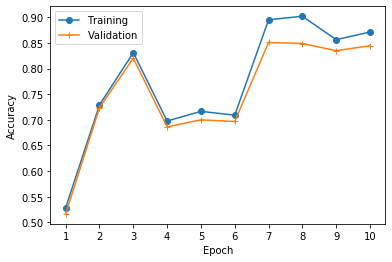

In [ ]:
num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 64  # during optimization, how many training data to use at each step
learning_rate = 0.01  # during optimization, how much we nudge our solution at each step

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               sequence=True)

UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

## Finally evaluate on test data

In [ ]:
test_dataset = imdb_dataset(train=False, test=True)

In [ ]:
test_encoded = [encoder.encode(data['text']) for data in test_dataset]

In [ ]:
test_labels = torch.tensor([int(data['sentiment'] == 'pos') for data in test_dataset])

In [ ]:
predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)

In [ ]:
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.84568


In [ ]:
UDA_pytorch_classifier_predict(simple_lstm_model,
                               [encoder.encode('this movie rocks')],
                               sequence=True)

tensor([1])

In [ ]:
UDA_pytorch_classifier_predict(simple_lstm_model,
                               [encoder.encode('this movie sucks')],
                               sequence=True)

tensor([0])

In [ ]:
UDA_pytorch_classifier_predict(simple_lstm_model,
                               [encoder.encode('this sucks')],
                               sequence=True)

tensor([0])